In [4]:
import pandas as pd
import numpy as np
import time
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from scipy import sparse
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from collections import Counter
import pickle
import ast

In [5]:
cd '/Users/Mengying/Desktop/Networks/Project'

/Users/Mengying/Desktop/Networks/Project


In [6]:
def save_obj(obj, name ):
    with open('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
# read in user taste profile data
profile = pd.read_table('Data/train_triplets.txt', names = ['user','song','count'])
profile.head() # 48,373,586

,user,song,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [5]:
unique_users = profile.groupby(['user'])['count'].sum()
unique_users.head() #1,019,318, close to 1M users' listening history

user
00000b722001882066dff9d2da8a775658053ea0    13
00001638d6189236866af9bbf309ae6c2347ffdc    56
0000175652312d12576d9e6b84f600caa24c4715    19
00001cf0dce3fb22b0df0f3a1d9cd21e38385372    25
0000267bde1b3a70ea75cf2b2d216cb828e3202b    27
Name: count, dtype: int64

In [6]:
unique_users.sort_values(ascending=False, inplace = True)
unique_users.tail() # the least number of times users have listened to in total: 10

user
0155cff3544ca02cc471d0d4ce1148c7f000ae7e    10
c35b8664d4dc68308e91934e1cdc28d34bee86f6    10
467ea4cb5fa300b650fa6b27b80495b4315db3bb    10
46842492af4e0c8aa6c5d6cb3ea6982873dea4e2    10
98b8b7dd46b150d5181f5674c0f8f686066f3b4e    10
Name: count, dtype: int64

In [6]:
## Unique songs
unique_songs = pd.unique(profile['song'])
unique_songs = pd.DataFrame(unique_songs, columns=['song_id'])
unique_songs.head() #384,546 songs

,song_id
0,SOAKIMP12A8C130995
1,SOAPDEY12A81C210A9
2,SOBBMDR12A8C13253B
3,SOBFNSP12AF72A0E22
4,SOBFOVM12A58A7D494


In [7]:
# https://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/unique_tracks.txt
unique_tracks_full = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/unique_tracks_full.txt',names = ['track_id','song_id','artist','song'],sep='<SEP>',engine='python')
unique_tracks_full.head()

,track_id,song_id,artist,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [8]:
full_profile = profile.merge(unique_tracks_full, left_on='song', right_on='song_id', how='left')
len(full_profile) #48,373,586 --> # 49,664,528 because some songs have 2-3 different track ids.

49664528

In [47]:
full_profile.drop(['song_x'],inplace=True, axis=1)
full_profile.head(11)

,user,count,track_id,song_id,artist,song_y
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIQAUQ128F42435AD,SOAKIMP12A8C130995,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIRLYL128F42539D1,SOAPDEY12A81C210A9,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,TRMHBXZ128F4238406,SOBBMDR12A8C13253B,Paco De Lucia,Entre Dos Aguas
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRYQMNI128F147C1C7,SOBFNSP12AF72A0E22,Josh Rouse,Under Cold Blue Stars
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRAHZNE128F9341B86,SOBFOVM12A58A7D494,The Dead 60s,Riot Radio (Soundtrack Version)
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRJPXGD128F92F17D7,SOBNZDC12A6D4FC103,Amset,Sin límites (I)
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,TRPLAXZ128F4292406,SOBSUJE12A6D4F8CF5,Jorge Drexler,12 segundos de oscuridad
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TREGAVI128F147C1CA,SOBVFZR12A6D4F8AE3,Josh Rouse,Ears To The Ground (Album Version)
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRZYZWL128F4277AD2,SOBXALG12A8C13C108,Eric Hutchinson,Food Chain (Album Version)
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRHNCIR128F42334A5,SOBXHDL12A81C204C0,Kanye West,Stronger


In [48]:
# Restrict to 1M songs
music_1M = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/music_all.csv',encoding="utf-8")
music_1M['track_id'] = music_1M['track_id'].apply(lambda s: s[2:-1])

In [51]:
music_1M.head()

,track_id,duration,loudness,tempo,song_hotness,artist_hotness,key_confidence,mode_confidence,release_year,artist_id,artist_tag
0,TRAAAAW128F429D538,218.93179,-11.197,92.198,0.602120,0.401998,0.736,0.636,0,b'ARD7TVE1187B99BFB1',[]
1,TRAAABD128F429CF47,148.03546,-9.843,121.274,NaN,0.417500,0.169,0.430,1969,b'ARMJAGH1187FB546F3',[b'classic pop and rock']
2,TRAAADZ128F9348C2E,177.47546,-9.689,100.070,NaN,0.343428,0.643,0.565,0,b'ARKRRTF1187B9984DA',[]
3,TRAAAEF128F4273421,233.40363,-9.013,119.293,NaN,0.454231,0.751,0.749,1982,b'AR7G5I41187FB4CE6C',[b'uk' b'british' b'english']
4,TRAAAFD128F92F423A,209.60608,-4.501,129.738,0.604501,0.401724,0.092,0.371,2007,b'ARXR32B1187FB57099',[]


In [52]:
profile_merge1M = full_profile.merge(music_1M, left_on = "track_id", right_on ="track_id", how='inner')

In [63]:
profile_merge1M.head() # (772661, 16)

,user,count,track_id,song_id,artist,song_y,duration,loudness,tempo,song_hotness,artist_hotness,key_confidence,mode_confidence,release_year,artist_id,artist_tag
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk']
1,833c530ecda3d99deb8395f70400aa3999783d91,2,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk']
2,d6c5bd2b570b4faf8964d7ed04f3392ff505d2be,1,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk']
3,724534729c9f5dc72a009269c2c225883e4775d2,1,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk']
4,ee7aa84c164038c963cfd02a7e52a5598aa470c3,2,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk']


In [55]:
check = profile_merge1M.groupby(['song_id'])['track_id'].nunique()

In [65]:
len(check[check.values >= 1])

3675

In [62]:
profile_merge1M.to_csv("/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/full_profile.csv",index=False)

In [177]:
# check for distribution for duplicated mapping
#check = full_profile.groupby(['song_id'])['track_id'].nunique()
#len(check[check.values >= 3]) # 632 for 1 song maps to 2 track_ids, 39 for 1 song maps to 3 track_ids. Not so many

39

In [199]:
# Indeed, we see close to 1M records duplicated, one song maps to multiple track_ids.
#full_profile['is_dup'] = full_profile.duplicated(['user','song_id','artist','song_y'])
#len(full_profile[full_profile.is_dup == True]) # 1,115,522

1115522

In [184]:
# Example of duplicates. Multiple track_ids(2) maps to same song_id
#full_profile[(full_profile.user == 'b80344d063b5ccb3212f76538f3d9e43d87dca9e') & (full_profile.song_x == 'SOBXHDL12A81C204C0')]

,user,song_x,count,track_id,song_id,artist,song_y
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,SOBXHDL12A81C204C0,Kanye West,Stronger
10,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,SOBXHDL12A81C204C0,Kanye West,Stronger


In [203]:
# We only look at the song level let's drop the duplicated song_id's for a user. 
# full_profile = full_profile[full_profile.is_dup == False]
# full_profile.drop(['is_dup'], axis=1, inplace=True)
#full_profile.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/full_profile.csv',index=False)

In [3]:
profile_merge1M = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/full_profile.csv')

In [7]:
profile_merge1M.groupby(['user'])['count'].sum().describe()

count    418252.000000
mean          4.958936
std           8.689989
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         772.000000
Name: count, dtype: float64

In [10]:
user_count = profile_merge1M.groupby(['user'])['count'].sum()
old_users = user_count[user_count.values>=5]

In [16]:
partial = profile_merge1M[profile_merge1M.user.isin(old_users.index)]

In [21]:
partial.groupby(['user']).count().shape

(126186, 15)

In [25]:
profile_merge1M = partial

### Create train/test split 8:2

In [51]:
# Read in cluster
music_cluster = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Music_Cluster/cluster_predict_noid.csv')

In [268]:
music_cluster['track_id'] = music_cluster['track_id'].apply(lambda s: s[2:-1])

In [24]:
music_cluster['predict'][music_cluster.track_id == 'TRAAAAW128F429D538'].values # 74 cluster

array([29])

In [26]:
profile_merge1M = profile_merge1M.merge(music_cluster,left_on='track_id',right_on='track_id',how='left')
profile_merge1M.head()

,user,count,track_id,song_id,artist,song_y,duration,loudness,tempo,song_hotness,artist_hotness,key_confidence,mode_confidence,release_year,artist_id,artist_tag,predict
0,833c530ecda3d99deb8395f70400aa3999783d91,2,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk'],19
1,724534729c9f5dc72a009269c2c225883e4775d2,1,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk'],19
2,ee7aa84c164038c963cfd02a7e52a5598aa470c3,2,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk'],19
3,1aa4fd215aadb160965110ed8a829745cde319eb,1,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk'],19
4,25de778286850a775207ae849df1004a1eeba820,15,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk'],19


In [52]:
np.random.seed(6080) # 3675 songs. 418,252 users
train_records = np.random.choice(len(profile_merge1M), int(len(profile_merge1M)*0.95),replace=False)
train = profile_merge1M.iloc[train_records,] #(351679, 16), 124257 users 3650 songs
test = profile_merge1M[~ profile_merge1M.index.isin(train_records)] #(18510, 16), 16960 users, among which 25537 cold start

In [53]:
test = test[(test.user.isin(train.user.unique())) & (test.track_id.isin(train.track_id.unique()))] # (16482,14) records, 15017 users with warm start      

In [56]:
test.groupby(['user']).count().shape

(15017, 16)

In [57]:
# unique songs appeared in training data [Yuying]
# train_songs = pd.unique(train['song_id'])
# train_songs = pd.DataFrame(train_songs, columns = ['song_id'])

le_track = preprocessing.LabelEncoder()
le_user = preprocessing.LabelEncoder()
train = train.copy()
train['track_label'] = le_track.fit_transform(train['track_id'])
train['user_label']= le_user.fit_transform(train['user'])
train.head()

,user,count,track_id,song_id,artist,song_y,duration,loudness,tempo,song_hotness,artist_hotness,key_confidence,mode_confidence,release_year,artist_id,artist_tag,predict,track_label,user_label
3004,93b58bd2feab229d599a119c6e3ede2d5e46829d,1,TRAQVTO128F14696A6,SONJBQX12A6D4F8382,Daft Punk,Da Funk,329.53424,-5.019,111.201,0.862255,1.021256,0.055,0.419,1995,b'ARF8HTQ1187B9AE693',[b'french' b'electronic' b'wp musicians' b'eur...,23,1670,71627
47230,c30ef473f8260e912a68fdf974ef021d3ab354d5,7,TRAURYF128F147805D,SOIZLKI12A6D4F7B61,Muse,Supermassive Black Hole (Album Version),209.34485,-3.313,120.010,0.760348,0.750427,0.034,0.503,0,b'ARR3ONV1187B9A2F59',[],68,2035,94636
254400,558e6f49f9455e5b51e67d7935a5e340c50c8625,3,TRANCOS128F4267DFB,SOJSGWO12AF72A2C49,Mando Diao,All My Senses,251.03628,-5.403,119.346,0.645983,0.486825,0.312,0.457,2004,b'ARR6MOS1187B994C51',[b'su\xc3\xa9dois' b'garage rock' b'swedish' b...,2,1304,41473
143020,269c71b2e37e7988ec005da553479f16194a1435,2,TRADYQK128F42A762A,SORJVDO12AF72A1970,Muse,Stockholm Syndrome,296.95955,-4.854,128.134,0.776351,0.750427,0.476,0.445,0,b'ARR3ONV1187B9A2F59',[],9,410,18697
54452,3fa78fdd6924662970f5141a90afbf55cb25883d,1,TRAAKDG128F42A0ECB,SOEHWGF12A6D4F8B2B,Shakira Featuring Wyclef Jean,Hips Don't Lie (featuring Wyclef Jean),217.36444,-5.152,100.023,0.737385,0.682263,0.805,0.688,0,b'AR6PJ8R1187FB5AD70',[b'colombian' b'classic pop and rock' b'espa\x...,29,51,30841


In [443]:
test['track_label'] = le_track.transform(test['track_id'])
test['user_label']= le_user.transform(test['user'])

In [12]:
#train.shape
len(pd.unique(profile_merge1M['user']))

418252

In [41]:
len(train['track_id'].unique()) # 3360

3360

In [42]:
#train['count'].sort_values(ascending=False)
train['count'].describe()

count    351679.000000
mean          4.152713
std           7.584245
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         771.000000
Name: count, dtype: float64

In [58]:
# Make training aggregated at cluster level
train_clustered = pd.DataFrame(train.groupby(['user_label','predict'])['count'].sum())
train_clustered = train_clustered.reset_index()
train_clustered.head()

,user_label,predict,count
0,0,12,1
1,0,37,4
2,1,36,3
3,1,53,1
4,1,72,6


In [61]:
#cluster_dt = train_clustered.groupby(['predict'])['count'].sum()
cluster_dt.describe()

count       72.000000
mean     20283.638889
std      24991.875246
min          6.000000
25%       2118.500000
50%       7715.000000
75%      31538.000000
max      92598.000000
Name: count, dtype: float64

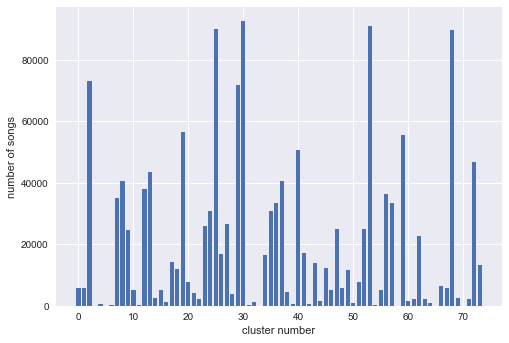

In [62]:
plt.style.use('seaborn')
plt.bar(cluster_dt.index, cluster_dt.values)
plt.xlabel('cluster number')
plt.ylabel('number of songs')
plt.show()

In [76]:
profile_merge1M.head(1)

,user,count,track_id,song_id,artist,song_y,duration,loudness,tempo,song_hotness,artist_hotness,key_confidence,mode_confidence,release_year,artist_id,artist_tag,predict
0,833c530ecda3d99deb8395f70400aa3999783d91,2,TRAUCNU128F42671EB,SOWEZSI12A81C21CE6,Gipsy Kings,Tu Quieres Volver,194.87302,-8.403,165.006,0.778821,0.540631,0.351,0.318,1987,b'AR2UQQ51187B9AC816',[b'classic pop and rock' b'folk'],19


### Collaborative Filtering -> Finding similar users

In [226]:
# global dict
SONG_AVG = dict(train['count'].groupby(train['track_id']).mean()) # {song: song_avg_count}
USER_AVG = dict(train['count'].groupby(train['user']).mean())
CLUSTER_AVG = dict(train_clustered['count'].groupby(train_clustered['predict']).mean())

In [420]:
SONG_Q = dict(train['count'].groupby(train['track_id']).quantile()) # q=0.5

In [227]:
CLUSTER_AVG

{0: 3.9080079417604234,
 1: 3.235361000568505,
 2: 5.4558274884345623,
 4: 4.4174757281553401,
 6: 3.0919540229885056,
 7: 4.4415171184930635,
 8: 4.0049198071435601,
 9: 3.2561699881219481,
 10: 4.0776071139854491,
 11: 12.222222222222221,
 12: 3.7874675713430452,
 13: 9.9935572940635069,
 14: 3.0994219653179189,
 15: 3.6258596973865198,
 16: 6.4780219780219781,
 17: 5.3058431952662719,
 18: 4.8070388349514559,
 19: 5.304241741741742,
 20: 4.4783625730994148,
 21: 3.7306642402183803,
 22: 3.7208931419457736,
 23: 4.2315086347344408,
 24: 3.9994822676676161,
 25: 4.5769836832206581,
 26: 3.8925297891842345,
 27: 4.5641332194705377,
 28: 3.2386081193040597,
 29: 4.1865324176463741,
 30: 5.4284206823777703,
 31: 1.7553191489361701,
 32: 3.4903581267217629,
 33: 1.75,
 34: 4.8595406360424027,
 35: 5.0150302238196369,
 36: 3.5716421097587019,
 37: 4.3575024097675916,
 38: 3.3656227239621268,
 39: 2.4183673469387754,
 40: 4.0585780773551594,
 41: 3.4770361298224128,
 42: 2.8978494623655915,

In [137]:
# de-meaned
train['demeaned_count'] = train.apply(lambda c: (c['count'] - USER_AVG[c['user']]), axis=1)
train.head(1)

,user,count,track_id,song_id,artist,song_y,duration,loudness,tempo,song_hotness,artist_hotness,key_confidence,mode_confidence,release_year,artist_id,artist_tag,predict,track_label,user_label,demeaned_count
3004,93b58bd2feab229d599a119c6e3ede2d5e46829d,1,TRAQVTO128F14696A6,SONJBQX12A6D4F8382,Daft Punk,Da Funk,329.53424,-5.019,111.201,0.862255,1.021256,0.055,0.419,1995,b'ARF8HTQ1187B9AE693',[b'french' b'electronic' b'wp musicians' b'eur...,23,1670,71627,-0.666667


In [147]:
# de-meaned training aggregated at cluster level
train_clustered['demeaned_count'] = train_clustered.apply(lambda c: (c['count'] - USER_CLUSTER_AVG[c['user_label']]), axis=1)
train_clustered.head(2)

,user_label,predict,count,demeaned_count
0,0,12,1,-1.5
1,0,37,4,1.5


In [444]:
#train_clustered.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/train_clustered.csv',index=False)
#train.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/train.csv',index=False)
#test.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/test.csv',index=False)

In [66]:
## Mapping raw id to integer id for users and tracks
all_users = list(le_user.classes_)
users_dict = dict(zip(all_users,range(len(all_users))))
all_tracks = list(le_track.classes_)
tracks_dict = dict(zip(all_tracks,range(len(all_users))))
clusters_dict = dict(zip(profile_merge1M.track_id,profile_merge1M['predict'])) # 3382 songs

In [153]:
# save dict maping
save_obj(users_dict,'users_dict')
save_obj(tracks_dict,'tracks_dict')
save_obj(clusters_dict,'clusters_dict')

In [7]:
################### read csv and load obj here
train = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/train.csv')
test = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/test.csv')
train_clustered = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/train_clustered.csv')

users_dict = load_obj('users_dict')
tracks_dict = load_obj('tracks_dict')
clusters_dict = load_obj('clusters_dict')

In [158]:
# user-song
M=sparse.coo_matrix((train['count'],(train.loc[:,'user_label'], train.loc[:,'track_label'])), shape = (392715,3650),dtype=int)
M_csr = M.tocsr()

In [159]:
# user-song_cluster
C=sparse.coo_matrix((train_clustered['count'],(train_clustered.loc[:,'user_label'],train_clustered.loc[:,'predict'])), shape = (392715,74),dtype=int)
C_csr = C.tocsr()

In [157]:
# train_clustered[train_clustered.demeaned_count==0] # issue with demeaned: if the user only listened in one cluster, then it's driven to 0  

,user_label,predict,count,demeaned_count
11,4,30,5,0.0
19,6,36,15,0.0
26,8,68,20,0.0
27,9,55,6,0.0
42,14,30,21,0.0
43,15,24,5,0.0
49,18,24,14,0.0
57,21,53,21,0.0
60,23,49,6,0.0
61,24,36,12,0.0


In [67]:
np.sum(M_csr[:,0]) # track

38

In [426]:
def predict_CF(data):
    # only deal with warm start, cold start row is left blank
    qcount = 0
    start = time.time()
    for index, row in data.iterrows():
        qcount += 1
    
        if qcount % 10 == 0:
            end = time.time()
            print("---time:", qcount, "  ", end - start)
            start = end
        try:
            u_ind = users_dict[row['user']]
        except:
            #print('erro user')
            continue
        try:
            t_ind = tracks_dict[row['track_id']]
            c_ind = row['predict']
        except:
            #print('erro track')
            continue

        clusters_position = C_csr[u_ind,].nonzero()[1] # find which clusters of music the user has ever listened to
        num_cluster = len(clusters_position)
        
        if num_cluster == 0: # new user
            continue 


        potentials = set()
        count = 0 
        for i in clusters_position:
            if count == 0:
                potentials = set(C_csr[:, i].nonzero()[0])
                count += 1
            else:
                potentials =  potentials & set(C_csr[:, i].nonzero()[0])
                count += 1
        
        filtered_potentials = []
        for p in potentials:
            if len(C_csr[p,].nonzero()[0]) > num_cluster+2:
                continue
            else:
                filtered_potentials.append(p)
                

        
        #print('prune after: ', len(filtered_potentials))
        
        if len(filtered_potentials) == 0:
            print('filtered potentials = 0')
            filtered_potentials = potentials
        
       
        
    
        top=0 # for final weighted average prediction
        bottom=0

        target = C_csr[u_ind,:] # user's listening cluser history
        tiled_dim = [target]*len(filtered_potentials)
        target = sparse.vstack(tiled_dim)  # to compute cos_similarity, we broadcast to match dimension nx74 
   
        sim = cosine_similarity(target,C_csr[filtered_potentials,:], dense_output=True) # movie_num*movie_num
       
        #sim_sorted = np.sort(sim[0,])
        very_sim = list(np.where((sim[0,] >= 0.6))[0]) # array([0, 1, 2])
        #very_sim = sim_sorted[-50:]
        #print(very_sim[-3:])
        if len(very_sim) > 0: # if there's similar user
            selected_id = "b'"+row['track_id']+"'"
            selected_track = ast.literal_eval(df_featurelist[df_featurelist['track_id']== selected_id].feature_list.item())

            for i in very_sim:
                #i = int(i)
                her_count = M_csr[i,t_ind] # SONG 
                if her_count > 0: # this similar person has heard this SONG
                    top += sim[0,i]*her_count
                    bottom += sim[0,i]
                else: # what about similar song?
                    
                    her_similars = train[(train.user_label == i) & (train.predict == c_ind)][['track_id','count']]

                    for sim_i in her_similars.track_id:
                        i_d = "b'"+sim_i+"'"
                        other_track=ast.literal_eval(df_featurelist[df_featurelist['track_id']== i_d].feature_list.item())
                        score = cosine_similarity_spatial(selected_track,other_track)
                        if score >= 0.85:
                            top += sim[0,i]*score*her_similars[her_similars.track_id == sim_i]['count'].values[0]
                            bottom += sim[0,i]*score         

            if bottom > 0:
                
                CF_pred = top/bottom
                data.loc[index,'CF_raw'] = CF_pred

                if CF_pred <= 2:
                    data.loc[index,'CF'] = 0
                elif CF_pred <=4:
                    data.loc[index,'CF'] = 1
                else:
                    data.loc[index,'CF'] = 2
               
            else:
                print(len(very_sim))
                data.loc[index,'CF'] = -99 # I cannot find very similary users that have listened to new cluster
                print (index,": Default -99")
        else:
            data.loc[index,'CF'] = -1 # I cannot find very similar users
            
        data.loc[index,'SONG_AVG'] = SONG_AVG[row['track_id']]
        data.loc[index,'SONG_Q'] = SONG_Q[row['track_id']]

In [335]:
her_similars = train[(train.user_label == 91)][['track_id','count','predict']]
her_similars['track_id'] = her_similars.apply(lambda r: "b'"+r['track_id']+"'",axis=1)
other_track=ast.literal_eval(df_featurelist[df_featurelist['track_id']== "b'TRBGGYE128F42B63AB'"].feature_list.item())
selected_track = ast.literal_eval(df_featurelist[df_featurelist['track_id']== "b'TRBDQUF128F42AE54C'"].feature_list.item())
cosine_similarity_spatial(selected_track,other_track) 

,track_id,count,predict
359377,b'TRBGGYE128F42B63AB',13,49
279024,b'TRALROP128F92CA9CC',2,26
281673,b'TRAAFJW128F428A424',1,62
253909,b'TRANVZT128F42AE134',1,34
358120,b'TRBEELS128F42B63A8',9,24


In [425]:
train[train.track_id == 'TRAACQT128F9331780']['count'].describe()

count    13.000000
mean      3.461538
std       2.933013
min       1.000000
25%       1.000000
50%       4.000000
75%       5.000000
max      11.000000
Name: count, dtype: float64

In [427]:
predict_CF(test_cluster_batch)
## test
#test_cluster_batch['CF'].value_counts()

1
117512 : Default -99
1
287695 : Default -99
---time: 10    43.45856690406799
1
277638 : Default -99
1
258564 : Default -99
1
81362 : Default -99
---time: 20    48.45255517959595
3
52502 : Default -99
1
159077 : Default -99
1
359250 : Default -99
1
124232 : Default -99
1
223464 : Default -99
1
285899 : Default -99
---time: 30    15.606668949127197
1
147488 : Default -99
1
350488 : Default -99
1
317604 : Default -99
1
15255 : Default -99
2
257613 : Default -99
---time: 40    18.603320121765137
1
270435 : Default -99
1
22987 : Default -99
6
89699 : Default -99
---time: 50    59.58868885040283
1
214766 : Default -99
1
133085 : Default -99
1
271239 : Default -99
1
326168 : Default -99
1
78744 : Default -99
---time: 60    7.036958932876587
5
31538 : Default -99
1
47126 : Default -99
1
343479 : Default -99
---time: 70    11.002808094024658
34
241204 : Default -99
1
349304 : Default -99
1
293035 : Default -99
1
150966 : Default -99
1
353259 : Default -99
---time: 80    2.2449779510498047
4
2

7
49585 : Default -99
1
24262 : Default -99
15
319162 : Default -99
---time: 660    15.423182725906372
1
318094 : Default -99
3
278561 : Default -99
1
147648 : Default -99
1
247732 : Default -99
4
39655 : Default -99
---time: 670    15.58019208908081
1
261657 : Default -99
1
8985 : Default -99
1
30118 : Default -99
1
30875 : Default -99
9
324515 : Default -99
---time: 680    15.964149951934814
1
120244 : Default -99
1
131479 : Default -99
1
335675 : Default -99
1
363354 : Default -99
---time: 690    23.477463960647583
1
141945 : Default -99
1
233422 : Default -99
1
259545 : Default -99
1
349877 : Default -99
---time: 700    15.897372007369995
1
243733 : Default -99
5
131102 : Default -99
1
315755 : Default -99
4
216520 : Default -99
1
356403 : Default -99
2
248992 : Default -99
4
261282 : Default -99
5
257445 : Default -99
---time: 710    1.0039572715759277
1
205862 : Default -99
1
349977 : Default -99
1
99541 : Default -99
1
292909 : Default -99
1
239063 : Default -99
---time: 720    

1
106958 : Default -99
1
234332 : Default -99
1
236110 : Default -99
1
220882 : Default -99
---time: 1290    43.12141990661621
3
344683 : Default -99
1
300891 : Default -99
1
316746 : Default -99
1
232872 : Default -99
---time: 1300    81.18773698806763
5
280529 : Default -99
4
170437 : Default -99
1
66280 : Default -99
2
298427 : Default -99
1
254745 : Default -99
1
224507 : Default -99
---time: 1310    15.431711912155151
7
238538 : Default -99
2
287086 : Default -99
1
291549 : Default -99
2
250030 : Default -99
1
302990 : Default -99
---time: 1320    59.46033310890198
3
315522 : Default -99
1
49521 : Default -99
1
308806 : Default -99
1
347874 : Default -99
2
88287 : Default -99
1
330931 : Default -99
---time: 1330    47.15710783004761
13
26713 : Default -99
---time: 1340    58.49755907058716
1
297406 : Default -99
1
302420 : Default -99
4
79951 : Default -99
5
249213 : Default -99
---time: 1350    44.60096216201782
4
152391 : Default -99
1
232830 : Default -99
3
131099 : Default -99

In [445]:
test_cluster_batch['track_label'] = le_track.transform(test_cluster_batch['track_id'])
test_cluster_batch['user_label']= le_user.transform(test_cluster_batch['user'])

In [446]:
#test_cluster_batch.to_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/test_cluster_batch.csv',index=False)

In [431]:
test_cluster_batch['CF'].value_counts()

-99.0    608
 2.0     396
 1.0     366
 0.0     115
Name: CF, dtype: int64

In [440]:
test_cluster_batch['like'].value_counts()

0    946
2    304
1    235
Name: like, dtype: int64

In [438]:
len(test_cluster_batch[test_cluster_batch['like'] == test_cluster_batch['CF']])/(1485-608)

0.3055872291904219

In [442]:
test.columns

Index(['user', 'count', 'track_id', 'song_id', 'artist', 'song_y', 'duration',
       'loudness', 'tempo', 'song_hotness', 'artist_hotness', 'key_confidence',
       'mode_confidence', 'release_year', 'artist_id', 'artist_tag', 'predict',
       'CF', 'dummy'],
      dtype='object')

In [433]:
test_cluster_batch[['count','like','CF','CF_raw','SONG_AVG','SONG_Q']].head(10)

,count,like,CF,CF_raw,SONG_AVG,SONG_Q
275508,8,2,2.0,9.616318,8.628472,5.0
117512,2,0,-99.0,NaN,2.935185,1.0
256111,9,2,1.0,3.353521,3.427536,1.0
287695,1,0,-99.0,NaN,4.314410,2.0
38893,14,2,1.0,3.879612,4.144224,2.0
194583,17,2,1.0,3.000000,3.792100,1.0
346440,2,0,1.0,3.858094,3.707865,1.0
268995,1,0,2.0,10.099252,5.566667,3.0
113149,1,0,1.0,3.242805,3.261937,2.0
192586,8,2,2.0,4.679400,5.642336,2.0


In [238]:
### Prepare test data
test['dummy'] = test.apply(lambda s: 1 if s['predict'] in C_csr[users_dict[s['user']],].nonzero()[1] else 0,axis=1 )
#test.groupby(['dummy'])['user'].count() # 14847, droppig 1635 people
test_cluster = test[test.dummy == 0]

In [230]:
def like_degree(row):
    if row['count'] <= 2:
        return 0
    elif row['count'] <=4:
        return 1
    else:
        return 2

In [243]:

test_cluster['like'] = test_cluster.apply(lambda row: like_degree(row),axis=1) 

/anaconda3/envs/si618/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [246]:
test_cluster_batch = test_cluster.sample(frac=0.1, random_state = 506)
test_cluster_batch.shape

(1485, 20)

In [247]:
test_cluster_batch['count'].describe()

count    1485.000000
mean        3.470707
std         6.828767
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       180.000000
Name: count, dtype: float64

In [225]:
test_cluster['count'].describe() # differentiate between 25%, 75%

count    14847.000000
mean         3.432815
std          6.242445
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        282.000000
Name: count, dtype: float64

In [257]:
## does predicting cluster level make sense? -> No. Should be at song level
train[train.predict == 10]['count'].describe()

count    1273.000000
mean        3.962294
std         6.121297
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        63.000000
Name: count, dtype: float64

#### Helper Function to retrieve top N similar songs from cluster

In [275]:
# Read in cluster
music_cluster = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Music_Cluster/cluster_predict_noid.csv')

In [276]:
df_featurelist = pd.read_csv("MSD/Music_Cluster/track_feature_list.csv")

In [282]:
from scipy import spatial
 
def cosine_similarity_spatial(x, y):
    return(1 - spatial.distance.cosine(x, y))

#df_cluster: the dataframe for track cluster assignment
#df_featurelist: the dataframe with the track_id and feature list
#cluster_id: needed retrieving cluster
#track_id: needed track from that cluster
#sim_number: get this top number of similartiy songs to return

def get_similar_song(df_cluster, df_featurelist, cluster_id, track, sim_number):
    track_list = list(df_cluster[df_cluster.predict==cluster_id].track_id)
    df_selected = pd.DataFrame(columns=['track_id','sim_score'])
    selected_track=df_featurelist[df_featurelist['track_id']== track].feature_list.item()
    selected_track=ast.literal_eval(selected_track)
    sim_score_list = []
    if track not in track_list:
        print("ERROR: ",track, "is not in cluster", cluster_id) 
        return
    else:
        for i in track_list:
            other_track=ast.literal_eval(df_featurelist[df_featurelist['track_id']== i].feature_list.item())
            sim_score_list.append(cosine_similarity_spatial(selected_track,other_track))
    df_selected['track_id']=track_list
    df_selected['sim_score']=sim_score_list
    
    df_sorted = df_selected.sort_values(by=['sim_score'], ascending=False)
    plus_itself=sim_number+1
    df_wanted = df_sorted.iloc[:plus_itself,:]
    
    return df_wanted

In [279]:
df=get_similar_song(music_cluster, df_featurelist, 3, "b'TRADVJK12903CC7D31'", 5)
df

,track_id,sim_score
0,b'TRADVJK12903CC7D31',1.000000
4,b'TRAMGZV128F426FAB3',0.999967
5,b'TRANOPO128F4217958',0.999904
2,b'TRAGEHE128F423E5A1',0.999879
8,b'TRBGNVA128F92F6C7A',0.999855
7,b'TRBBWKS128F424E84A',0.999571


In [290]:
df_featurelist[df_featurelist['track_id']== "b'TRADVJK12903CC7D31'"].feature_list.item()

'[914.02404, -7.329, 107.43299999999999, 0.0, 0.5479999999999999, 0.5479999999999999]'

In [ ]:
testlist=list(music_cluster[music_cluster.predict==3].track_id)
for i in testlist:
    print(i)

#### Plot: Only on train data

In [91]:
SONG_COUNT = train['count'].groupby(train['track_id']).sum()

In [93]:
count_frequency = SONG_COUNT.groupby(SONG_COUNT.values).count()
count_frequency = pd.DataFrame({'frequency':count_frequency.index , 'count':count_frequency.values})
count_frequency.head()

,count,frequency
0,191,1
1,150,2
2,117,3
3,93,4
4,116,5


In [94]:
filtered_count_freq = count_frequency[count_frequency['count'] > 2]

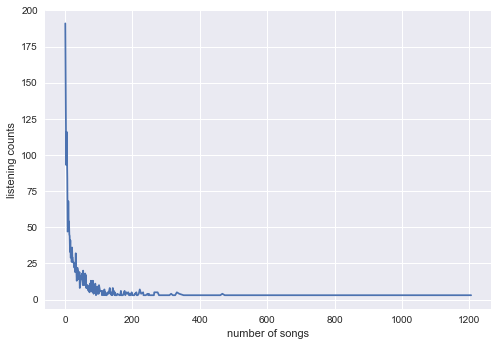

In [96]:
plt.style.use('seaborn')
plt.plot(filtered_count_freq['frequency'], filtered_count_freq['count'])
plt.xlabel('number of songs')
plt.ylabel('listening counts')
plt.show()

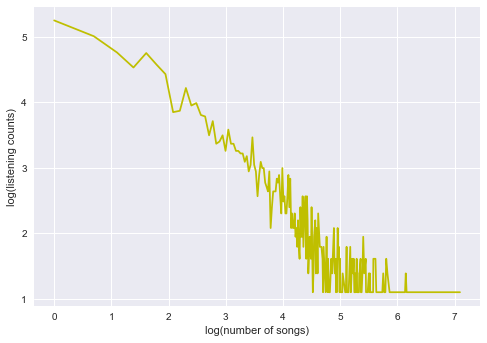

In [97]:
plt.plot(np.log(filtered_count_freq['frequency']), np.log(filtered_count_freq['count']), 'y')
plt.xlabel('log(number of songs)')
plt.ylabel('log(listening counts)')
plt.show()

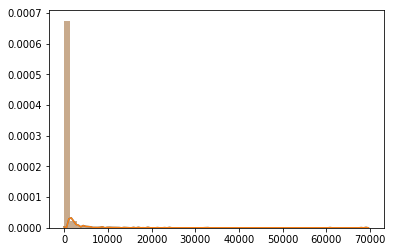

In [106]:
sns.distplot(filtered_SONG_COUNT.values)
plt.show()

In [86]:
# Encode user and song id to make integer position 
track_encoder = preprocessing.LabelEncoder()
train['TRACK_ID'] = track_encoder.fit_transform(train['track_id'])
user_encoder = preprocessing.LabelEncoder()
train['USER_ID'] = user_encoder.fit_transform(train['user'])

/anaconda3/envs/si618/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/si618/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [89]:
train.track_id.unique().shape[0] # train: 3612, test: 2979, 2916 common track_id, 3675 union

3612